# Combined network: 

- Encoder-decoder unit --> Local network with self-supervised learning --> mimic PV?

- Encoder-classifier unit --> Global network with supervised learning --> mimic SST?


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Dataset

In [3]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [40]:
from modules.network import PV_SST_Pyr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10).to(device)

print(model)

PV_SST_Pyr(
  (encoder): encoder(
    (flatten): Flatten()
    (activation): Sigmoid()
    (fc1): Linear(in_features=784, out_features=32, bias=True)
  )
  (decoder): decoder(
    (activation): Sigmoid()
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=784, bias=True)
  )
  (classifier): classifier(
    (fc1): Linear(in_features=32, out_features=10, bias=True)
    (activation): Sigmoid()
  )
)


In [41]:
for name, param in model.named_parameters():
    print (name)   

encoder.fc1.weight
encoder.fc1.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
classifier.fc1.weight
classifier.fc1.bias


### Train & test

In [42]:
from modules.utils import print_grad_norms, compute_losses
from modules.metrics import calculate_ssim, calculate_accuracy
from modules.metrics import visualize_tsne, plot_digits
#from modules.metrics import  tsne_and_clustering, plot_digits_and_saliency
from modules.utils import weight_update_v1, successive_learning



momentum = 0.5
loss_fn = nn.MSELoss()


num_epochs = 140
log_interval = 400
alpha = 1 
lr = 1

train_losses, train_recon_losses, train_global_losses  = [], [], []
train_ssim, train_acc = [], []
train_counter = []
test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

def train(epoch, dataloader, model, loss_fn, alpha):
    recon_loss_avg, global_loss_avg, loss_avg, total, correct = 0,0,0,0,0
    model.train() 
    for batch_idx, batch in enumerate(dataloader):
        thal_input, target = batch 
        t = F.one_hot(target, num_classes=10).float()
        _, recon, output = model(thal_input)

        alpha, lr = successive_learning(epoch, model)
        #model.freeze_module('encoder')
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        #optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)
        ssim_score = calculate_ssim(recon, thal_input)
        _, _, accuracy = calculate_accuracy(target, output, total, correct)
        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()

        weight_update_v1(model, optimizer, recon_loss, global_loss, total_loss)
        optimizer.step()
        optimizer.zero_grad()
        
        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_ssim.append(ssim_score)
            train_acc.append(accuracy)
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))
            #print_grad_norms(model.encoder, "Encoder")
            #print_grad_norms(model.decoder, "Decoder")
            #print_grad_norms(model.classifier, "Classifier")

    recon_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, loss_avg))
    print('Epoch: {} Recon_loss: {:.6f} Global_loss: {:.6f}  Total loss: {:.6f}'.format(
        epoch, recon_loss_avg, global_loss_avg, loss_avg))
    
    


ImportError: cannot import name 'weight_update_v1' from 'modules.utils' (/Users/irismarmouset-delataille/Desktop/RPC rotation/LocalGlobal_CostFunctions/modules/utils.py)

In [43]:
def test(dataloader, model, loss_fn, alpha, epoch=None):
    model.eval()
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg,total, correct = 0,0,0,0,0,0
    encoded_outputs = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            thal_input, target = batch
            t = F.one_hot(target, num_classes=10).float()
            encoded, recon, output = model(thal_input)

            alpha, _ = successive_learning(epoch, model)
            #model.freeze_module('encoder')
            recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)
            ssim_score = calculate_ssim(recon, thal_input)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            ssim_avg += ssim_score
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            encoded_outputs.append(encoded)
            labels.append(target)
                  
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg))
    test_ssim.append(ssim_avg)
    test_acc.append(100 * correct / total)
    test_losses.append(test_loss_avg)
    encoded_outputs = torch.cat(encoded_outputs)
    labels = torch.cat(labels)
    if epoch is None or (epoch is not None and epoch % 10 == 0):
            #silhouette_score = tsne_and_clustering(encoded_outputs, labels, epoch)
            #test_silhouette.append(silhouette_score)
            visualize_tsne(encoded_outputs, labels, epoch)
            plot_digits(model, dataloader, n=5,swap_argument=None, epoch=epoch)
            #plot_digits_and_saliency(model, dataloader, n=5,swap_argument=None, epoch=epoch)
            #print('Silhouette score: {}'.format(silhouette_score))
    print('Test set: Recon_loss: {:.6f} Global_loss: {:.6f} Acc: {}   SSIM {:.6f} \n'.format(
        recon_loss_avg, global_loss_avg, 100 * correct / total, ssim_avg))

In [44]:
test(test_data_loader, model, loss_fn, alpha)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, loss_fn, alpha)
  test(test_data_loader, model, loss_fn, alpha, epoch)

Test set: Recon_loss: 1.264744 Global_loss: 0.215533 Acc: 9.69   SSIM -0.035718 

Epoch: 1 Recon_loss: 0.829658 Global_loss: 0.212675  Total loss: 0.829658
Test set: Recon_loss: 0.833110 Global_loss: 0.212848 Acc: 8.92   SSIM 0.039403 

Epoch: 2 Recon_loss: 0.829175 Global_loss: 0.212671  Total loss: 0.829175
Test set: Recon_loss: 0.833110 Global_loss: 0.212848 Acc: 8.92   SSIM 0.039403 

Epoch: 3 Recon_loss: 0.829223 Global_loss: 0.212672  Total loss: 0.829223
Test set: Recon_loss: 0.833110 Global_loss: 0.212848 Acc: 8.92   SSIM 0.039403 

Epoch: 4 Recon_loss: 0.829195 Global_loss: 0.212673  Total loss: 0.829195
Test set: Recon_loss: 0.833110 Global_loss: 0.212848 Acc: 8.92   SSIM 0.039403 

Epoch: 5 Recon_loss: 0.829193 Global_loss: 0.212672  Total loss: 0.829193
Test set: Recon_loss: 0.833110 Global_loss: 0.212848 Acc: 8.92   SSIM 0.039403 

Epoch: 6 Recon_loss: 0.829184 Global_loss: 0.212673  Total loss: 0.829184
Test set: Recon_loss: 0.833110 Global_loss: 0.212848 Acc: 8.92   SSIM

KeyboardInterrupt: 

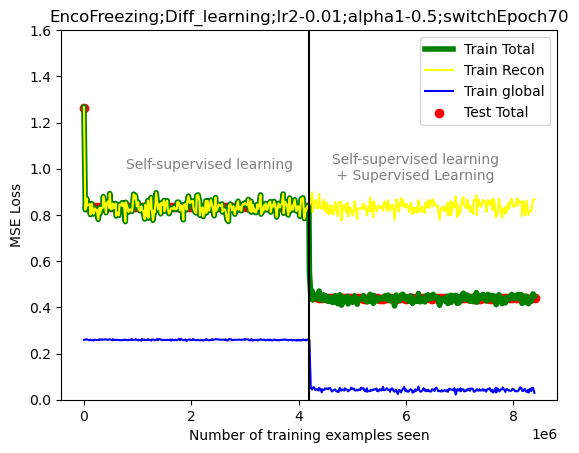

In [80]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green', linewidth = 4)
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train global', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 1.6])
#plt.ylim([0, 2.1])
plt.ylabel('MSE Loss')

#plt.vlines(70*len(train_data_loader.dataset),0, 1.6, color='black')
plt.vlines(70*len(train_data_loader.dataset),0, 1.6, color='black')
plt.text(13*len(train_data_loader.dataset), 1, 'Self-supervised learning', fontsize=10, color='grey')
plt.text(77*len(train_data_loader.dataset), 0.95, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')

plt.title(f"EncoFreezing;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70")
#plt.savefig(f'./Plots/Losses/EncoFreezing;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70.png', dpi=300, bbox_inches='tight')
plt.show()

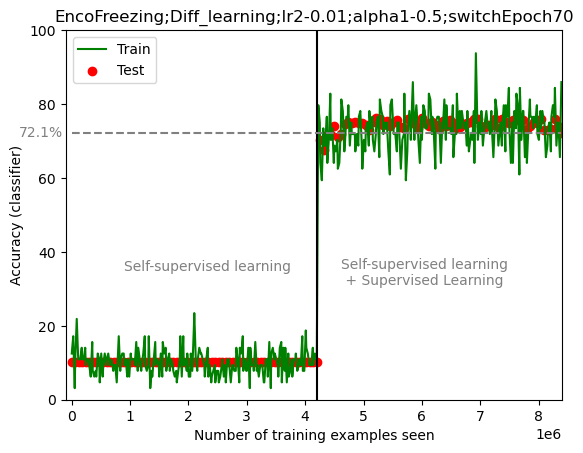

In [82]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_acc, color='green')
plt.scatter(test_counter, test_acc, color='red')
plt.legend(['Train','Test'], loc='upper left')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 100])
plt.xlim([-100000, num_epochs*len(train_data_loader.dataset)])
plt.ylabel('Accuracy (classifier)')
plt.vlines(70*len(train_data_loader.dataset),0, 100, color='black')
plt.text(15*len(train_data_loader.dataset), 35, 'Self-supervised learning', fontsize=10, color='grey')
plt.text(77*len(train_data_loader.dataset), 31, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')
last_test_acc = round(test_acc[-1], 1)
plt.hlines(last_test_acc, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-900000, last_test_acc, f'{last_test_acc}%', fontsize=10, verticalalignment='center', color='grey')

plt.title(f"EncoFreezing;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70")
#plt.savefig(f'./Plots/Accuracies/EncoFreezing;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70.png', dpi=300, bbox_inches='tight')
plt.show()

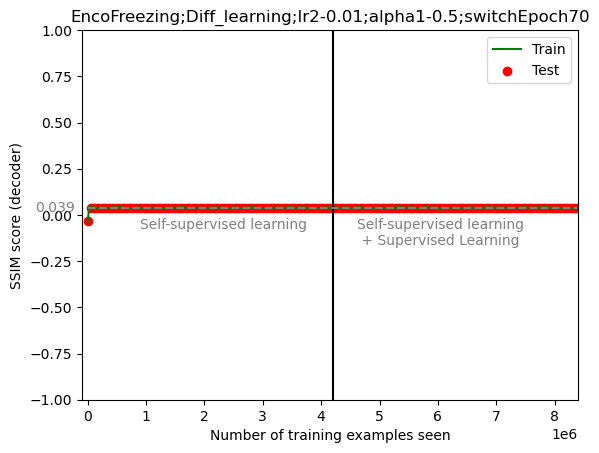

In [90]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_ssim, color='green')
plt.scatter(test_counter, test_ssim, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
#plt.ylim([-0.1, 0.2])
plt.ylim([-1, 1])
plt.xlim([-100000, num_epochs*len(train_data_loader.dataset)])
plt.ylabel('SSIM score (decoder)')
#plt.vlines(70*len(train_data_loader.dataset),-0.1, 0.2, color='black')
plt.vlines(70*len(train_data_loader.dataset),-1, 1, color='black')
plt.text(15*len(train_data_loader.dataset), -0.075, 'Self-supervised learning', fontsize=10, color='grey')
plt.text(77*len(train_data_loader.dataset), -0.16, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')
# plt.text(77*len(train_data_loader.dataset), -0.090, 'Self-supervised learning\n + Supervised Learning', fontsize=10, color='grey')


last_test_ssim = round(test_ssim[-1], 3)
plt.hlines(last_test_ssim, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-900000, last_test_ssim, f'{last_test_ssim}', fontsize=10, verticalalignment='center', color='grey')

plt.title(f"EncoFreezing;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70") 
plt.savefig(f'./Plots/SSIM/EncoFreezing;Diff_learning;lr2-0.01;alpha1-0.5;switchEpoch70_2.png', dpi=300, bbox_inches='tight')
plt.show()
